In [ ]:
! /opt/bin/nvidia-smi

Thu Apr  1 02:28:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/")

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2021-04-21 04:50:48--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.217.26.81, 3.211.204.50, 18.205.129.29, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.217.26.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13828408 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.2’

ngrok-stable-linux- 100%[===================>]  13.19M  1.66MB/s    in 9.4s    

2021-04-21 04:50:59 (1.40 MB/s) - ‘ngrok-stable-linux-amd64.zip.2’ saved [13828408/13828408]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ngrok                   


In [ ]:
!npm install -g localtunnel

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.1
added 22 packages from 22 contributors in 1.351s


In [ ]:
!./ngrok authtoken 1qeHZQGMohDfI3mcIsJ5mxR2Yuz_2chjRiWxH9wutoNW6xnCj

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
# get_ipython().system_raw('python3 -m pip install visdom')
# get_ipython().system_raw('python3 -m visdom.server -port 9998 >> visdomlog.txt 2>&1 &')
get_ipython().system_raw('lt --port 9998 >> url.txt 2>&1 &')

# !visdom -port 9998
# !curl -s http://localhost:4040/api/tunnels

# !lt --port 9998 >> url.txt 2>&1 &
import time
time.sleep(1)

!cat url.txt


your url is: https://quick-walrus-46.loca.lt


In [ ]:
import visdom
vis = visdom.Visdom(port='9998')

Setting up a new session...


In [ ]:
import sys, os, random, datetime, json
import torch, torchvision
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

from torch.utils.data import DataLoader, Dataset
from torch.nn.functional import one_hot

In [ ]:
IMAGESIZE = 16
WINDOWSIZE = IMAGESIZE * IMAGESIZE
BATCHSIZE=1024
EPOCH = 5000
INPUTCHANNEL = 4

CNN1_IN_CHANNEL = 4
CNN1_OUT_CHANNEL = 4
CNN1_KERNEL_SIZE = 3
CNN2_OUT_CHANNEL = 24
CNN2_KERNEL_SIZE = 3
CNN3_OUT_CHANNEL = 48
CNN3_KERNEL_SIZE = 3
FC1_OUTPUT_SIZE = 512
FC2_OUTPUT_SIZE = 64

In [ ]:
raw_normal = np.load("normal_simple_{}_{}.npy".format(IMAGESIZE,INPUTCHANNEL))
raw_sepsis = np.load("sepsis_simple_{}_{}.npy".format(IMAGESIZE,INPUTCHANNEL))

In [ ]:
print(raw_normal.shape, raw_sepsis.shape)

(25583, 256, 4) (4235, 256, 4)


In [ ]:
# 在本地算好的每个特征的最大最小值
maxValue = np.array([297,154,100,20])
minValue = np.array([8, 0.0213,3.5217,0.02])

In [ ]:
# 把数据缩放到[0,1]
# 转成（4，IMAGESIZE, IMAGESIZE)
normal_reshaped = []
sepsis_reshaped = []
for item in raw_normal:
    normal_reshaped.append(
        ((item - minValue) / maxValue).reshape(IMAGESIZE, IMAGESIZE, INPUTCHANNEL).transpose(2,0,1)
    )
for item in raw_sepsis:
    sepsis_reshaped.append(
        ((item - minValue) / maxValue).reshape(IMAGESIZE, IMAGESIZE, INPUTCHANNEL).transpose(2,0,1)
    )

In [ ]:
# 不缩放到[0,255]
normal_reshaped = []
sepsis_reshaped = []
for item in raw_normal:
    normal_reshaped.append(
        item.reshape(IMAGESIZE, IMAGESIZE, INPUTCHANNEL).transpose(2,0,1).astype(np.int32)
    )
for item in raw_sepsis:
    sepsis_reshaped.append(
        item.reshape(IMAGESIZE, IMAGESIZE, INPUTCHANNEL).transpose(2,0,1).astype(np.int32)
    )

In [ ]:
# 平衡两类数据
sample_index = random.sample(range(len(normal_reshaped)), len(sepsis_reshaped))
normal_reshaped = [normal_reshaped[i] for i in sample_index]
len_total = len(sample_index)
print(len_total)

4235


In [ ]:
# 划分训练测试集
X = normal_reshaped+sepsis_reshaped
y = np.concatenate((np.zeros(len_total), np.ones(len_total)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=890708)

train_list = [[X_train[i], y_train[i]] for i in range(len(y_train))]
test_list = [[X_test[i], y_test[i]] for i in range(len(y_test))]

In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data_list):
        self.data = data_list
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

def my_collate(data):
    x = np.array([d[0] for d in data])
    y = np.array([d[1] for d in data])
    return x, y

In [ ]:
train_set = MyDataset(train_list)
test_set = MyDataset(test_list)

train_loader = DataLoader(train_set, batch_size=BATCHSIZE, shuffle=True, collate_fn=my_collate)
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=True, collate_fn=my_collate)

In [ ]:
# 建立神经网络

class NET(torch.nn.Module):
    def __init__(
        self,
        cnn1_in_channel=4,
        cnn1_out_channel=4,
        cnn1_kernel_size=3,
        cnn2_out_channel=24,
        cnn2_kernel_size=3,
        cnn3_out_channel=48,
        cnn3_kernel_size=3,
        fc1_output_size=512,
        fc2_output_size=64,
        dilation1 = 1,
        dilation2 = 2,
        dilation3 = 4,
    ):
        super(NET, self).__init__()

        self.cnn2_out_channel = cnn2_out_channel

        self.cnn1_1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=cnn1_in_channel,
                out_channels=cnn1_out_channel,
                kernel_size=cnn1_kernel_size,
                padding = ((dilation1-1) * (cnn1_kernel_size-1) + cnn1_kernel_size - 1) // 2,
                dilation=dilation1,
            ),
            torch.nn.BatchNorm2d(cnn1_out_channel),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )

        self.cnn1_2 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=cnn1_in_channel,
                out_channels=cnn1_out_channel,
                kernel_size=cnn1_kernel_size,
                padding = ((dilation2-1) * (cnn1_kernel_size-1) + cnn1_kernel_size - 1) // 2,
                dilation=dilation2,
            ),
            torch.nn.BatchNorm2d(cnn1_out_channel),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )

        self.cnn1_3 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=cnn1_in_channel,
                out_channels=cnn1_out_channel,
                kernel_size=cnn1_kernel_size,
                padding = ((dilation3-1) * (cnn1_kernel_size-1) + cnn1_kernel_size - 1) // 2,
                dilation=dilation3,
            ),
            torch.nn.BatchNorm2d(cnn1_out_channel),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )

        self.cnn2 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=cnn1_out_channel*3,
                out_channels=cnn2_out_channel,
                kernel_size=cnn2_kernel_size,
                padding = (cnn2_kernel_size - 1) // 2
            ),
            torch.nn.BatchNorm2d(cnn2_out_channel),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )

        self.cnn3 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=cnn2_out_channel,
                out_channels=cnn3_out_channel,
                kernel_size=cnn3_kernel_size,
                padding = (cnn3_kernel_size - 1) // 2
            ),
            torch.nn.BatchNorm2d(cnn3_out_channel),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )
        if IMAGESIZE == 32:
            self.cnn_output_size = cnn3_out_channel*(IMAGESIZE//8)**2 # for 32*32 images
        elif IMAGESIZE == 16:
            self.cnn_output_size = cnn3_out_channel*(IMAGESIZE//8)**2 # for 16*16 images
        self.fc1 = torch.nn.Linear(
            in_features=self.cnn_output_size, 
            out_features=fc1_output_size,
        )

        self.fc2 = torch.nn.Linear(
            in_features = fc1_output_size,
            out_features = fc2_output_size,
        )

        self.fc3 = torch.nn.Linear(
            in_features = fc2_output_size,
            out_features = 2,
        )
        self.relu = torch.nn.ReLU()
        self.dp = torch.nn.Dropout(0.5)
        self.sigmoid = torch.nn.Sigmoid()
        self.bn1 = torch.nn.BatchNorm1d(fc1_output_size)
        self.bn2 = torch.nn.BatchNorm1d(fc2_output_size)


    def forward(self, x):
        out1_1 = self.cnn1_1(torch.from_numpy(x).float().cuda())
        out1_2 = self.cnn1_2(torch.from_numpy(x).float().cuda())
        out1_3 = self.cnn1_3(torch.from_numpy(x).float().cuda())
        out = torch.cat([out1_1, out1_2, out1_3], dim=1)
        # print('cnn1 output:', out.shape)
        out = self.cnn2(out)
        # print('cnn2 output:', out.shape)
        out = self.cnn3(out)
        # print('cnn3 output:', out.shape)
        # sys.exit(1)
        out = out.reshape(-1, self.cnn_output_size)
        out = self.dp(out)
        out = self.fc1(out)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.dp(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.fc3(out)
        # out = self.sigmoid(out)
        return out

In [ ]:
class EarlyStop:
    def __init__(self, threshold=0.1, interval=10):
        self.minError = sys.maxsize
        self.threshold = threshold
        self.gl = np.zeros(interval)
        self.count = 0

    def add(self, gl:float) -> None:
        self.gl[self.count % 10] = gl
        self.count += 1
    
    def calc(self, loss:float) -> float:
        gl = loss/self.minError-1
        return gl

    def update(self, newValue:float) -> None:
        if newValue < self.minError:
            self.minError = newValue
            print('The Minimum Loss has been updated to {:.4f}'.format(newValue))
    
    def isStop(self, loss:float) -> float:
        self.update(loss)
        gl = self.calc(loss)
        self.add(gl)
        mgl = self.gl.mean()
        if mgl > self.threshold:
            print('mean validation error({:.4f}) beyond threshold {}'.format(mgl, self.threshold))
            return True
        return False

In [ ]:
vis.close("training")
vis.close("testing")
es = EarlyStop(threshold=0.1)

model = NET().cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# weights = torch.FloatTensor([1,5])
criterion = torch.nn.BCEWithLogitsLoss().cuda()
testing_loss = torch.nn.BCELoss(reduction="mean").cuda()
EARLYSTOPEPOCH = 0
ISSTOP = False

global_batch_iter = 0
for epoch in range(EPOCH):
    batch_iter = 0
    for x, y in train_loader:
        out = model(x)
        y_prob = F.softmax(out, dim=1)
        target = torch.from_numpy(y).long().cuda()
        target = F.one_hot(target, num_classes=2).float()
        # print(out.shape, target.shape)
        # sys.exit(1)
        loss = criterion(out, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # for name, parms in model.named_parameters():
        #     print('name:', name, 'grad_requirs:',parms.requires_grad, ' grad_value:',parms.grad)
        # sys.exit(1)
        batch_iter += 1
        global_batch_iter += 1

    with torch.no_grad():
        for X, y in test_loader:
            o = model(X)
            y_true = torch.from_numpy(np.array(y))  # [642]
            y_prob = F.softmax(o, dim=1).double().cpu()[:, 1]
            # print(y_true.shape)
            # print(y_prob.shape)
            # sys.exit(1)
            y_pred = torch.round(y_prob)
            # print(y_pred.shape)
            # sys.exit(1)
            acc = metrics.accuracy_score(y_pred, y_true)
            vis.line(
                X=[epoch + 1],
                Y=[acc],
                win="testing",
                update="append",
                opts=dict(title="testing accuracy", legend=["testing acc"]),
            )
            testing_bce = testing_loss(y_prob, y_true)
            vis.line(
                X=[epoch + 1],
                Y=[[loss.item(), testing_bce]],
                win="training",
                update="append",
                opts=dict(
                    title="training and testing error",
                    legend=["training loss", "testing loss"],
                ),
            )
            if es.isStop(testing_bce):
                EARLYSTOPEPOCH = epoch + 1
                ISSTOP = True
                break

    print(
        "Train Epoch: {:0>4d}\tLoss: {:.6f}\tTesting Loss: {:.6f}".format(
            epoch + 1, loss.item(), testing_bce
        )
    )
    if ISSTOP:
        print("early stop epoch: {}".format(EARLYSTOPEPOCH))
        break

The Minimum Loss has been updated to 0.7175
Train Epoch: 0001	Loss: 0.699748	Testing Loss: 0.717509
The Minimum Loss has been updated to 0.7023
Train Epoch: 0002	Loss: 0.688694	Testing Loss: 0.702335
The Minimum Loss has been updated to 0.6853
Train Epoch: 0003	Loss: 0.686980	Testing Loss: 0.685281
The Minimum Loss has been updated to 0.6746
Train Epoch: 0004	Loss: 0.682641	Testing Loss: 0.674632
The Minimum Loss has been updated to 0.6597
Train Epoch: 0005	Loss: 0.676937	Testing Loss: 0.659730
Train Epoch: 0006	Loss: 0.684099	Testing Loss: 0.664517
The Minimum Loss has been updated to 0.6484
Train Epoch: 0007	Loss: 0.654461	Testing Loss: 0.648405
The Minimum Loss has been updated to 0.6363
Train Epoch: 0008	Loss: 0.654181	Testing Loss: 0.636272
The Minimum Loss has been updated to 0.6273
Train Epoch: 0009	Loss: 0.644636	Testing Loss: 0.627276
The Minimum Loss has been updated to 0.6241
Train Epoch: 0010	Loss: 0.628338	Testing Loss: 0.624086
The Minimum Loss has been updated to 0.6099


In [ ]:
results_dic = {}

acc:0.6604
auc:0.7074
 f1:0.6572
215 116 102 209
fpr:0.3505
fnr:0.3280
              precision    recall  f1-score   support

         0.0       0.68      0.65      0.66       331
         1.0       0.64      0.67      0.66       311

    accuracy                           0.66       642
   macro avg       0.66      0.66      0.66       642
weighted avg       0.66      0.66      0.66       642



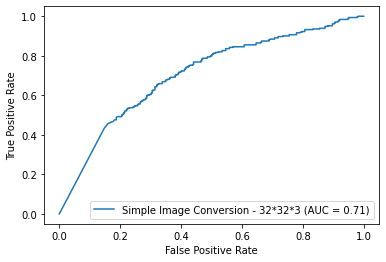

In [ ]:
sig = torch.nn.Sigmoid()
with torch.no_grad():
    x, y = iter(test_loader).next()
    y_prob = F.softmax(model(x), dim=1).cpu().detach().numpy()
    y_pred = (y_prob[:,1] > y_prob[:, 0]).astype(np.int32)
    y_true = torch.from_numpy(np.array(y))
    # ACC
    accuracy_score = metrics.accuracy_score(y_pred, y_true)
    print('acc:{:.4f}'.format(accuracy_score))
    results_dic['SIMPLE_{:0>3d}_{}'.format(IMAGESIZE, 'ACC')] = accuracy_score
    # AUC
    roc_auc_score = metrics.roc_auc_score(y_true, y_prob[:,1], average=None)
    print('auc:{:.4f}'.format(roc_auc_score))
    results_dic['SIMPLE_{:0>3d}_{}'.format(IMAGESIZE, 'AUC')] = roc_auc_score
    # F1
    f1_score = metrics.f1_score(y_true, y_pred)
    print(' f1:{:.4f}'.format(f1_score))
    results_dic['SIMPLE_{:0>3d}_{}'.format(IMAGESIZE, '_F1')] = f1_score
    # CONFUSION MATRIX
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    print(tn, fp, fn, tp)
    print('fpr:{:.4f}'.format(fp/(fp+tn)))
    print('fnr:{:.4f}'.format(fn/(fn+tp)))
    results_dic['SIMPLE_{:0>3d}_{}'.format(IMAGESIZE, 'FPR')] = fp/(fp+tn)
    results_dic['SIMPLE_{:0>3d}_{}'.format(IMAGESIZE, 'FNR')] = fn/(fn+tp)
    # Classificatin Report
    print(metrics.classification_report(y_true, y_pred))
    # ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_prob[:,1])
    roc_auc = metrics.auc(fpr, tpr)
    results_dic['SIMPLE_{:0>3d}_{}'.format(IMAGESIZE, 'ROC')] = roc_auc
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Simple Image Conversion - 32*32*3')
    display.plot()
    plt.show()

with open('simple_result.json', 'w') as f:
    json.dump(results_dic, f)